# Classifiers for all targets
Let's train classifiers for all target for different molecular represenatations and compare results. The next step will involve the optimization of hyperparameters for each classifier. `mlflow` will be used for experiment management.

In [17]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import polars as pl
from pathlib import Path
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

# add parent directory to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from metrics import ClassificationMetrics
from tools import expand_array_column, train_classifier

In [2]:
path_parquet = Path("../data/2023_09_12_papyrus1k_dataset_more_params_STD_MFP_lessColumns.parquet")
assert path_parquet.exists()

Load precomputed Morgan fingerprints:

In [3]:
path_fps = Path("../out/fingerprints_dicts/d_morgan.pkl")
assert path_fps.exists()

with open(path_fps, "rb") as f:
    d_morgan = pickle.load(f)

Load data and train classifier:

In [4]:
df = pl.read_parquet(path_parquet)

In [5]:
# select randomly 5 targets
random_targets = ['P35916_WT', 'O94806_WT', 'P48729_WT', 'P80457_WT', 'Q16665_WT', 'P53667_WT']

metrics_lst = []

for target_id in tqdm(random_targets):
# for target_id in tqdm(df["target_id"].unique().to_list()):

    df_target = df.filter(pl.col("target_id") == target_id)
    df_target = df_target.drop(["target_id", "STD_SELFIES"])

    df_target = df_target.with_columns(
        morgan_fp = pl.col("STD_SMILES").map_elements(lambda x: d_morgan[x])
    )

    df_target = expand_array_column(df_target, "morgan_fp", 2048)

    # Define the model
    model = RandomForestClassifier(n_estimators=1000, random_state=42)

    metrics = train_classifier(model, df_target, target_id)

    metrics_lst.append(metrics)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
metrics_lst

[Target: P35916_WT, train MCC: 1.0000, val MCC: 0.6606, test MCC: 0.6522.,
 Target: O94806_WT, train MCC: 1.0000, val MCC: 0.5962, test MCC: 0.3959.,
 Target: P48729_WT, train MCC: 1.0000, val MCC: 0.5531, test MCC: 0.1659.,
 Target: P80457_WT, train MCC: 0.9974, val MCC: 0.8608, test MCC: 0.9184.,
 Target: Q16665_WT, train MCC: 1.0000, val MCC: 0.3816, test MCC: 0.4183.,
 Target: P53667_WT, train MCC: 1.0000, val MCC: 0.6482, test MCC: 0.5121.]

Visualize `mcc_val` score distribution:

In [22]:
metrics_dicts = []

for metrics in metrics_lst:
    metrics_dict = {
        "target_id": metrics.target_id,
        "mcc_train": metrics.mcc_train,
        "mcc_val": metrics.mcc_val,
        "mcc_test": metrics.mcc_test
    }
    metrics_dicts.append(metrics_dict)

In [23]:
df_metrics = pl.DataFrame(metrics_dicts)

df_metrics

target_id,mcc_train,mcc_val,mcc_test
str,f64,f64,f64
"""P35916_WT""",1.0,0.660634,0.652213
"""O94806_WT""",1.0,0.596186,0.395912
"""P48729_WT""",1.0,0.553134,0.165859
"""P80457_WT""",0.99738,0.860753,0.918401
"""Q16665_WT""",1.0,0.381555,0.41833
"""P53667_WT""",1.0,0.648181,0.512095


In [24]:
# convert to pandas
df_metrics = df_metrics.to_pandas()

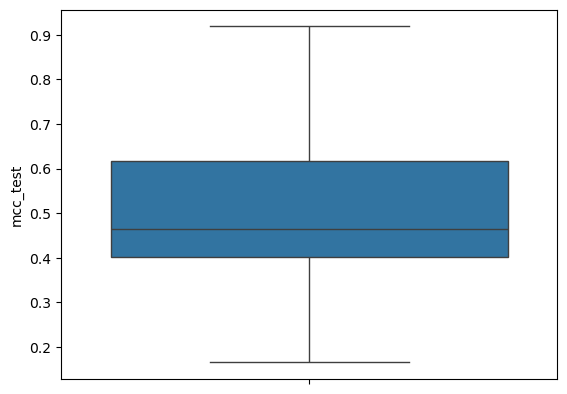

In [26]:
# violin plot
sns.boxplot(data=df_metrics, y="mcc_test");